In [1]:
import sys
import os
top_path = os.path.abspath('../')
if top_path not in sys.path:
    sys.path.insert(0, top_path)

# Third-party
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline
import h5py
from sklearn.neighbors import KDTree
from scipy.misc import logsumexp

from gwb.data import TGASStar
from gwb.likelihood import ln_H1_marg_v_likelihood, ln_H2_marg_v_likelihood
from gwb.fml import ln_H1_FML, ln_H2_FML

In [2]:
tgas_path = os.path.abspath("../../gaiadr1/data/tgas.hdf5")

In [3]:
with h5py.File(tgas_path, 'r') as f:
    tgas = f['tgas'][(f['tgas']['parallax'] / f['tgas']['parallax_error']) > 32]
len(tgas)

42385

In [4]:
c = coord.SkyCoord(ra=tgas['ra']*u.degree, dec=tgas['dec']*u.degree, distance=1000./tgas['parallax']*u.pc)

In [5]:
X = c.cartesian.xyz.T
tree = KDTree(X)
tree_d,tree_i = tree.query(X, k=2)
tree_d = tree_d[:,1]
tree_i = tree_i[:,1]

In [6]:
dvtan = np.sqrt((tgas['pmra']-tgas['pmra'][tree_i])**2 +
                (tgas['pmdec']-tgas['pmdec'][tree_i])**2) / tgas['parallax'] * 4.74

(-1, 25)

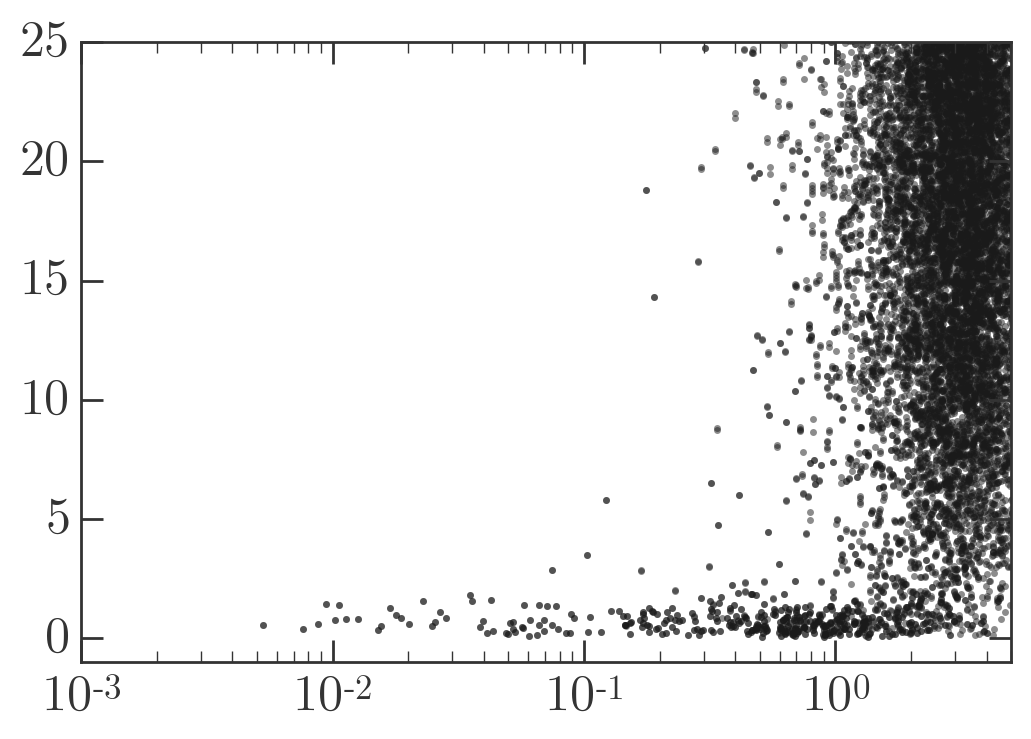

In [7]:
plt.semilogx(tree_d, dvtan, linestyle='none', alpha=0.5)
plt.xlim(1E-3, 5)
plt.ylim(-1,25)

In [10]:
# cut = dvtan < 2.
tgas1 = tgas#[cut]
tgas2 = tgas[tree_i]#[cut]
len(tgas1), len(tgas2)

(42385, 42385)

(-1, 10)

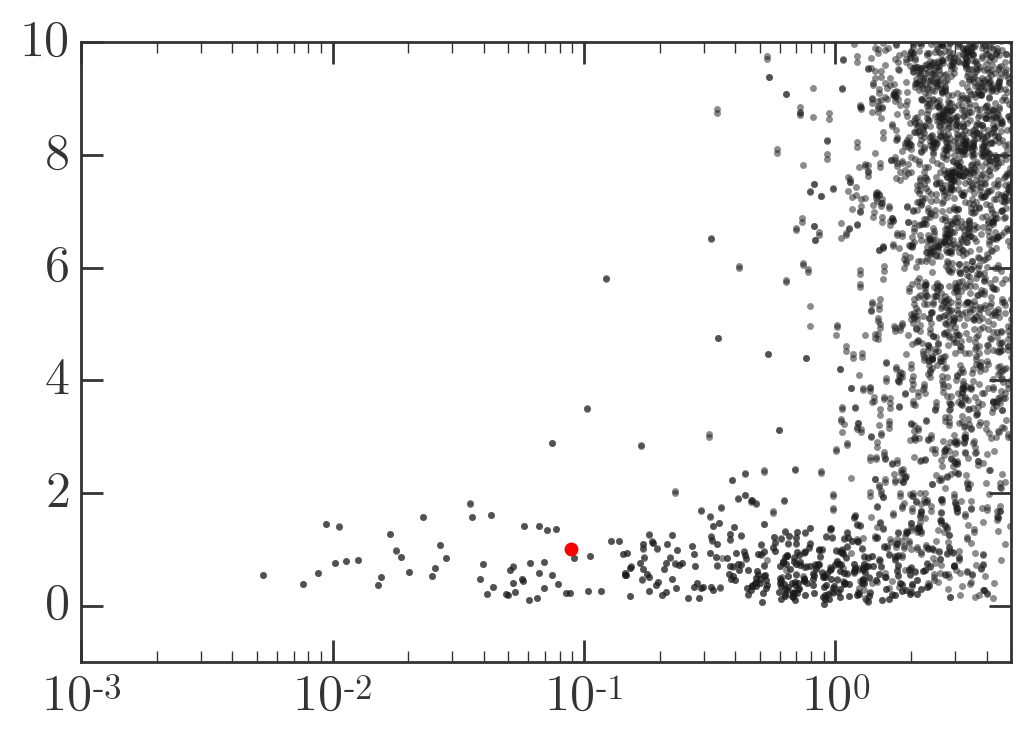

In [90]:
# pair_idx = np.where((dvtan > 2.5) & (dvtan < 5))[0][0]
# pair_idx = np.where((tree_d < 1) & (tree_d > 0.5) & (dvtan < 2) & (dvtan > 0))[0][8]
# pair_idx = np.where((tree_d < 1) & (tree_d > 0.5) & (dvtan < 8) & (dvtan > 4))[0][0]
pair_idx = np.where((tree_d < 0.12) & (tree_d > 0.08) & (dvtan < 2) & (dvtan > 0.))[0][0]

plt.semilogx(tree_d, dvtan, linestyle='none', alpha=0.5)
plt.semilogx(tree_d[pair_idx], dvtan[pair_idx], linestyle='none', alpha=1., marker='o', color='r')
plt.xlim(1E-3, 5)
plt.ylim(-1,10)

Velocity prior variance tensor

In [91]:
V = np.diag([25.]*3)**2 # (km/s)^2
Vinv = np.linalg.inv(V)

In [94]:
star1 = TGASStar(tgas1[pair_idx])
star2 = TGASStar(tgas2[pair_idx])

In [95]:
# artificially blow up proper motion for one of the stars
# star1 = TGASStar(tgas1[8])
# star2 = TGASStar(tgas2[8])

# star1.get_cov()
# star1._row['pmra'] += 5*star1._row['pmra_error']
# star1._row['pmdec'] += 5*star1._row['pmdec_error']

In [96]:
star1_d = star1.get_distance()
star2_d = star2.get_distance()
print(star1._parallax, star2._parallax)
print(star1_d, star2_d)

55.6869327524 55.9630557977
17.95859020065773 pc 17.870059583955666 pc


In [108]:
star1.ra, star1.dec, star1.pmra, star1.pmdec

(<Quantity 254.42509134226412 deg>,
 <Quantity 47.36323477890251 deg>,
 <Quantity -139.5355601873148 mas / yr>,
 <Quantity 262.1076913620685 mas / yr>)

In [111]:
star2.ra, star2.dec, star2.pmra, star2.pmdec

(<Quantity 254.4706813722491 deg>,
 <Quantity 47.36781792404047 deg>,
 <Quantity -146.9041302886281 mas / yr>,
 <Quantity 271.5242256818538 mas / yr>)

In [97]:
# d1_grid,d2_grid = np.meshgrid(np.linspace(1., 150, 64),
#                               np.linspace(1., 150, 64))
d2_grid,d1_grid = np.meshgrid(np.linspace(0.5*star1_d.value, 1.5*star1_d.value, 64),
                              np.linspace(0.5*star2_d.value, 1.5*star2_d.value, 64))

In [98]:
ln_H1_marg_v_likelihood(star1_d.value, star2_d.value, 
                        star1, star2, Vinv)

-3577.216501758272

In [99]:
ll_H1 = np.zeros_like(d1_grid)
ll_H2 = np.zeros_like(d1_grid)
for i,d1,d2 in zip(range(d1_grid.size), d1_grid.ravel(), d2_grid.ravel()):
    ll_H1.flat[i] = ln_H1_marg_v_likelihood(d1, d2, star1, star2, Vinv)
    ll_H2.flat[i] = ln_H2_marg_v_likelihood(d1, d2, star1, star2, Vinv)

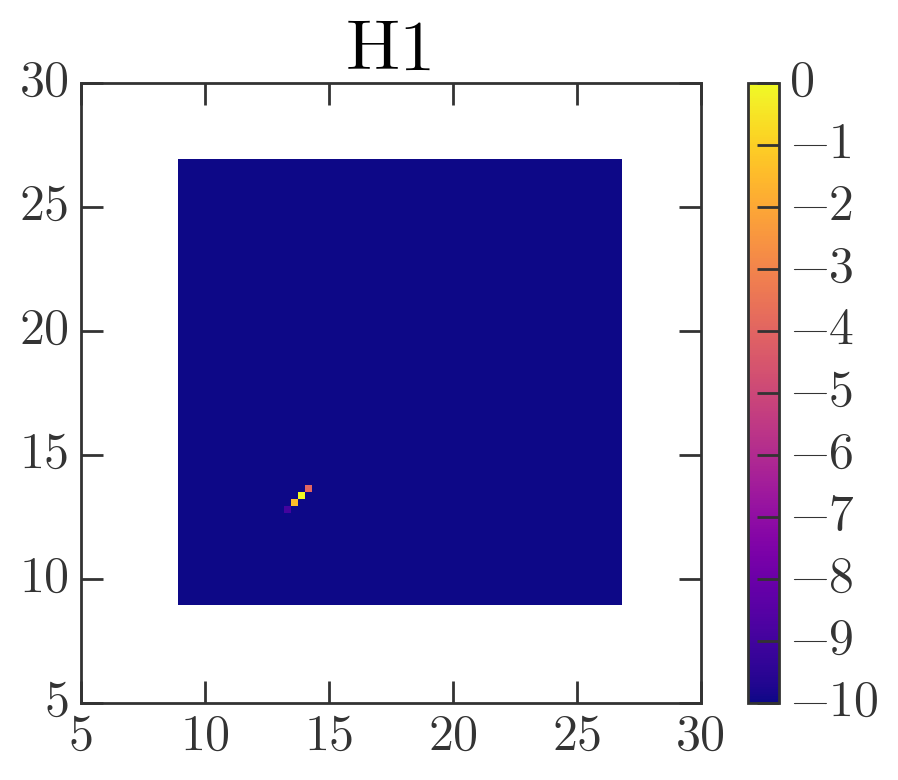

In [100]:
plt.pcolormesh(d1_grid, d2_grid, ll_H1-ll_H1.max(), 
               cmap='plasma', vmin=-10, vmax=0) #, norm=mpl.colors.LogNorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title("H1")

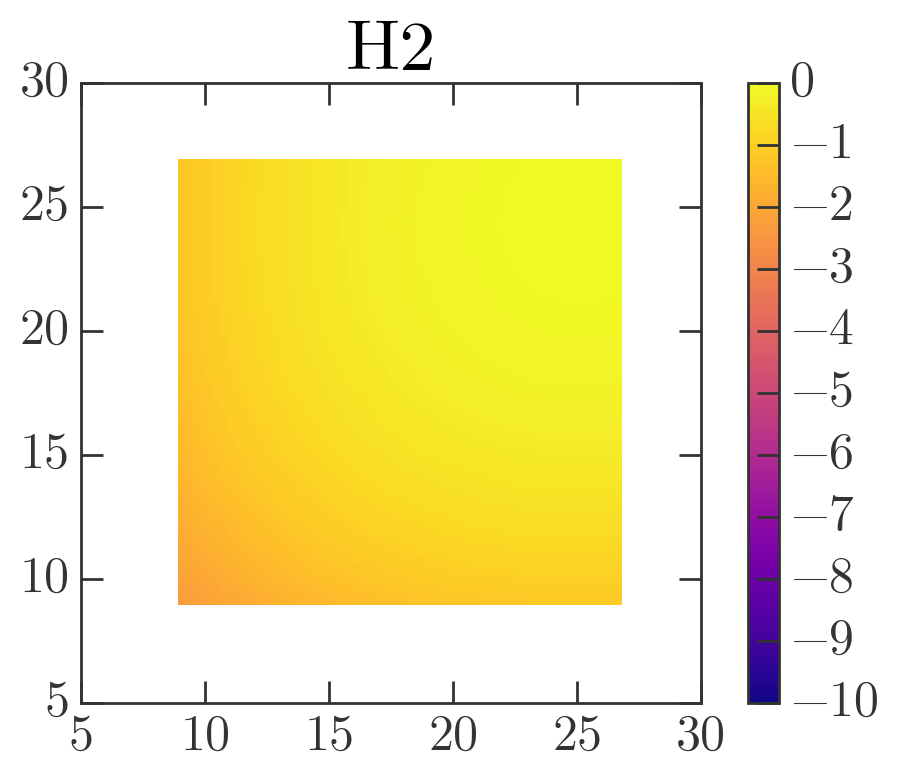

In [101]:
plt.pcolormesh(d1_grid, d2_grid, ll_H2-ll_H2.max(), 
               cmap='plasma', vmin=-10, vmax=0) #, norm=mpl.colors.LogNorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title("H2")

In [102]:
ll_ratio = ll_H1 - ll_H2

In [103]:
ll_ratio.min(), ll_ratio.max()

(-3079782.6542112743, -31.354141103647535)

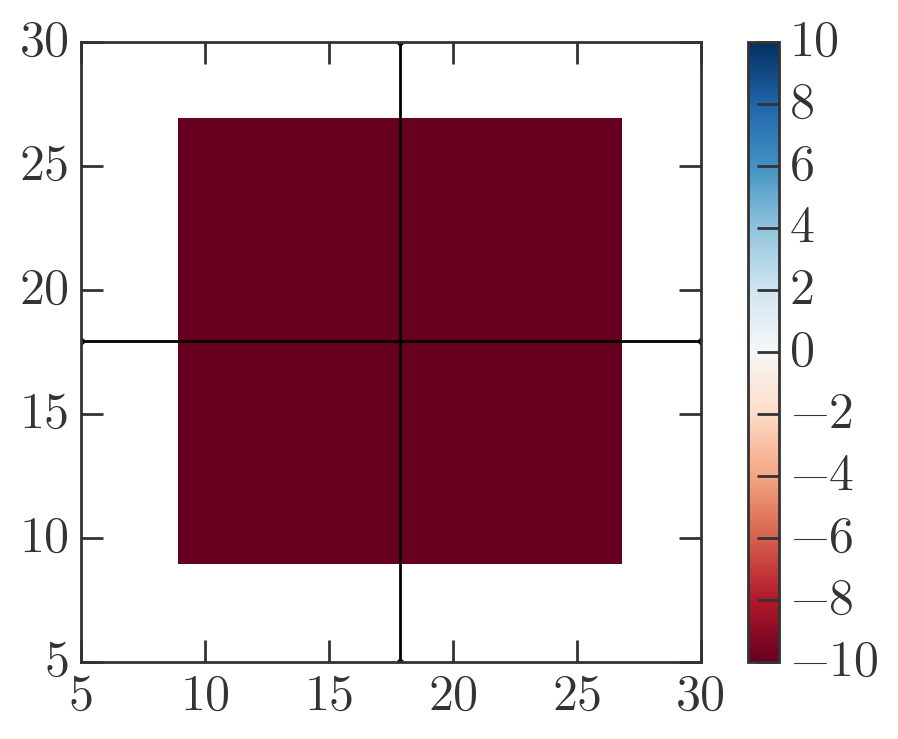

In [104]:
plt.pcolormesh(d1_grid, d2_grid, ll_ratio, 
               cmap='RdBu', vmin=-10, vmax=10) #, norm=mpl.colors.LogNorm())
plt.gca().set_aspect('equal')
plt.colorbar()
plt.axvline(star2_d.value)
plt.axhline(star1_d.value)

In [105]:
ln_H1_FML(star1, star2, Vinv) - ln_H2_FML(star1, star2, Vinv)

-1142.0587266515195

---

In [68]:
# # I'm so fired
# star1 = TGASStar(tgas1[8])
# star1.get_cov()

# for fac in np.arange(0, 6):
#     star1._cov[0,0] *= 2**fac
#     dist1 = get_posterior_distance_sampling(star1, size=16384, min_parallax=1000./256)
    
#     plt.figure()
#     plt.hist(dist1, bins=np.linspace(0, 256, 256))
#     plt.axvline(1000/star1._parallax, color='r')
#     plt.title("error factor: {}".format(2**fac))
#     plt.xlim(0, 256)

In [69]:
dist1 = get_posterior_distance_sampling(star1, size=32)
dist2 = get_posterior_distance_sampling(star2, size=32)
ll_H1 = logsumexp([ln_H1_marg_likelihood(d1, d2, star1, star2, Vinv) for d1,d2 in zip(dist1, dist2)])
ll_H2 = logsumexp([ln_H2_marg_likelihood(d1, d2, star1, star2, Vinv) for d1,d2 in zip(dist1, dist2)])

In [70]:
ll_H1, ll_H2

(-422.18961741048952, -15.701892022431629)